In [34]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
import os
import torch as ch
import numpy as np
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import torch.nn as nn

import matplotlib.pyplot as plt

from mib.models.utils import get_model
from mib.dataset.utils import get_dataset
from mib.attacks.utils import get_attack
from mib.utils import get_signals_path, get_models_path
from mib.attacks.theory import compute_trace
from mib.attacks.attack_utils import compute_scaled_logit, compute_gradients
from mib.attacks.batchnorm import get_bn_stats

from mib.attacks.theory import compute_trace

In [20]:
import matplotlib as mpl
import matplotlib.font_manager as fm

mpl.rcParams["figure.dpi"] = 300
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams["font.family"] = "Times New Roman"

In [21]:
def load_model(path):
    model_arch = "wide_resnet_28_2"
    model, _, _ = get_model(model_arch, 10)
    state_dict = ch.load(path)
    indices = state_dict["train_index"]
    model.load_state_dict(state_dict["model"], strict=False)
    model.eval()
    
    return model, indices

In [22]:
def member_nonmember_loaders(
    train_data,
    train_idx,
    num_nontrain_pool: int = None,
    batch_size: int = 1,
    want_all_member_nonmember: bool = False,
):
    seed = 2024
    num_points = 500
 
    other_indices_train = np.array(
        [i for i in range(len(train_data)) if i not in train_idx]
    )

    # Create Subset datasets for members
    if want_all_member_nonmember:
        train_index_subset = train_idx
    else:
        np.random.seed(seed)
        train_index_subset = np.random.choice(train_idx, num_points, replace=False)

    # Sample non-members
    np.random.seed(seed + 1)
    nonmember_indices = np.random.choice(
        other_indices_train, num_nontrain_pool, replace=False
    )

    if want_all_member_nonmember:
        nonmember_index_subset = nonmember_indices
    else:
        # Break nonmember_indices here into 2 - one for sprinkling in FT data, other for actual non-members
        nonmember_indices_ft = nonmember_indices[: num_nontrain_pool // 2]
        nonmember_indices_test = nonmember_indices[num_nontrain_pool // 2 :]

        nonmember_dset_ft = ch.utils.data.Subset(train_data, nonmember_indices_ft)

        # Sample non-members
        np.random.seed(seed + 2)
        nonmember_index_subset = np.random.choice(
            nonmember_indices_test, num_points, replace=False
        )

    # Make dsets
    member_dset = ch.utils.data.Subset(train_data, train_index_subset)
    nonmember_dset = ch.utils.data.Subset(
        train_data,
        nonmember_index_subset,
    )

    # Make loaders out of data
    member_loader = ch.utils.data.DataLoader(
        member_dset, batch_size=batch_size, shuffle=False
    )
    nonmember_loader = ch.utils.data.DataLoader(
        nonmember_dset, batch_size=batch_size, shuffle=False
    )

    if want_all_member_nonmember:
        return member_loader, nonmember_loader
    return (
        member_loader,
        nonmember_loader,
        nonmember_dset_ft,
        train_index_subset,
        nonmember_index_subset,
    )

In [23]:
ds = get_dataset("cifar10")(augment=False)
# CIFAR
num_nontrain_pool = 15000

# Get data
train_data = ds.get_train_data()

Files already downloaded and verified
Files already downloaded and verified


##### Compute trace values for LOO model for data-point 0

In [52]:
pick_dp = 1
path = f"/p/distinf/mib_cache/models/wide_resnet_28_2/l_mode/0/{pick_dp}/last_5"

traces_1 = []
for p in tqdm(os.listdir(path)):
    mpath = os.path.join(path, p)
    m, indices = load_model(mpath)
    m.cuda()
    (
        member_loader,
        nonmember_loader,
        nonmember_dset_ft,
        train_index_subset,
        nonmember_index_subset,
    ) = member_nonmember_loaders(
        train_data,
        indices,
        num_nontrain_pool
    )
    trace_value = compute_trace(m, member_loader, nonmember_loader, device="cuda", shift_model=False)
    m.cpu()
    traces_1.append(trace_value)
traces_1 = np.array(traces)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [20:46<00:00, 24.94s/it]


In [53]:
traces_1 = traces_1[traces_1 != np.inf]

##### Do the same, but for different-data models

In [38]:
path = f"/p/distinf/mib_cache/models/wide_resnet_28_2/last_5/"

traces_diff = []
for p in tqdm(os.listdir(path)):
    if os.path.isdir(os.path.join(path, p)):
        continue
    mpath = os.path.join(path, p)
    m, indices = load_model(mpath)
    m.cuda()
    (
        member_loader,
        nonmember_loader,
        nonmember_dset_ft,
        train_index_subset,
        nonmember_index_subset,
    ) = member_nonmember_loaders(
        train_data,
        indices,
        num_nontrain_pool
    )
    trace_value = compute_trace(m, member_loader, nonmember_loader, device="cuda", shift_model=False)
    m.cpu()
    traces_diff.append(trace_value)
    if len(traces_diff) == len(traces):
        break
traces_diff = np.array(traces_diff)

 49%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 49/100 [20:22<21:12, 24.95s/it]


In [39]:
traces_diff = traces_diff[traces_diff != np.inf]

In [42]:
traces

array([7.68444640e+07, 1.00856968e+08, 9.08976320e+07, 5.82457560e+07,
       9.23246320e+07, 4.53013000e+07, 3.02894260e+07, 9.69333360e+07,
       5.65086560e+07, 5.46762240e+07, 2.61392960e+07, 1.17542536e+08,
       5.43025440e+07, 7.18593040e+07, 5.30192640e+07, 7.72063440e+07,
       4.34539800e+07, 4.60663040e+07, 6.43212960e+07, 4.01942240e+07,
       5.16162000e+07, 1.35865792e+08, 5.62556600e+07, 9.37495200e+07,
       1.23604936e+08, 2.34733856e+08, 1.12842912e+08, 6.67574040e+07,
       7.69465360e+07, 1.30949528e+08, 9.37158000e+07, 1.41718976e+08,
       2.19379008e+08, 3.63047640e+07, 1.00627104e+08, 1.17875160e+08,
       1.43529200e+08, 7.36092960e+07, 5.00049360e+07, 1.21544248e+08,
       9.65082320e+07, 9.99384560e+07, 1.58368288e+08, 1.81920160e+08,
       8.91393840e+07, 7.16704640e+07, 7.00107200e+07, 7.35531520e+07,
       2.16101520e+08, 1.66974832e+08], dtype=float32)

<AxesSubplot: xlabel='log10(Trace)', ylabel='Probability'>

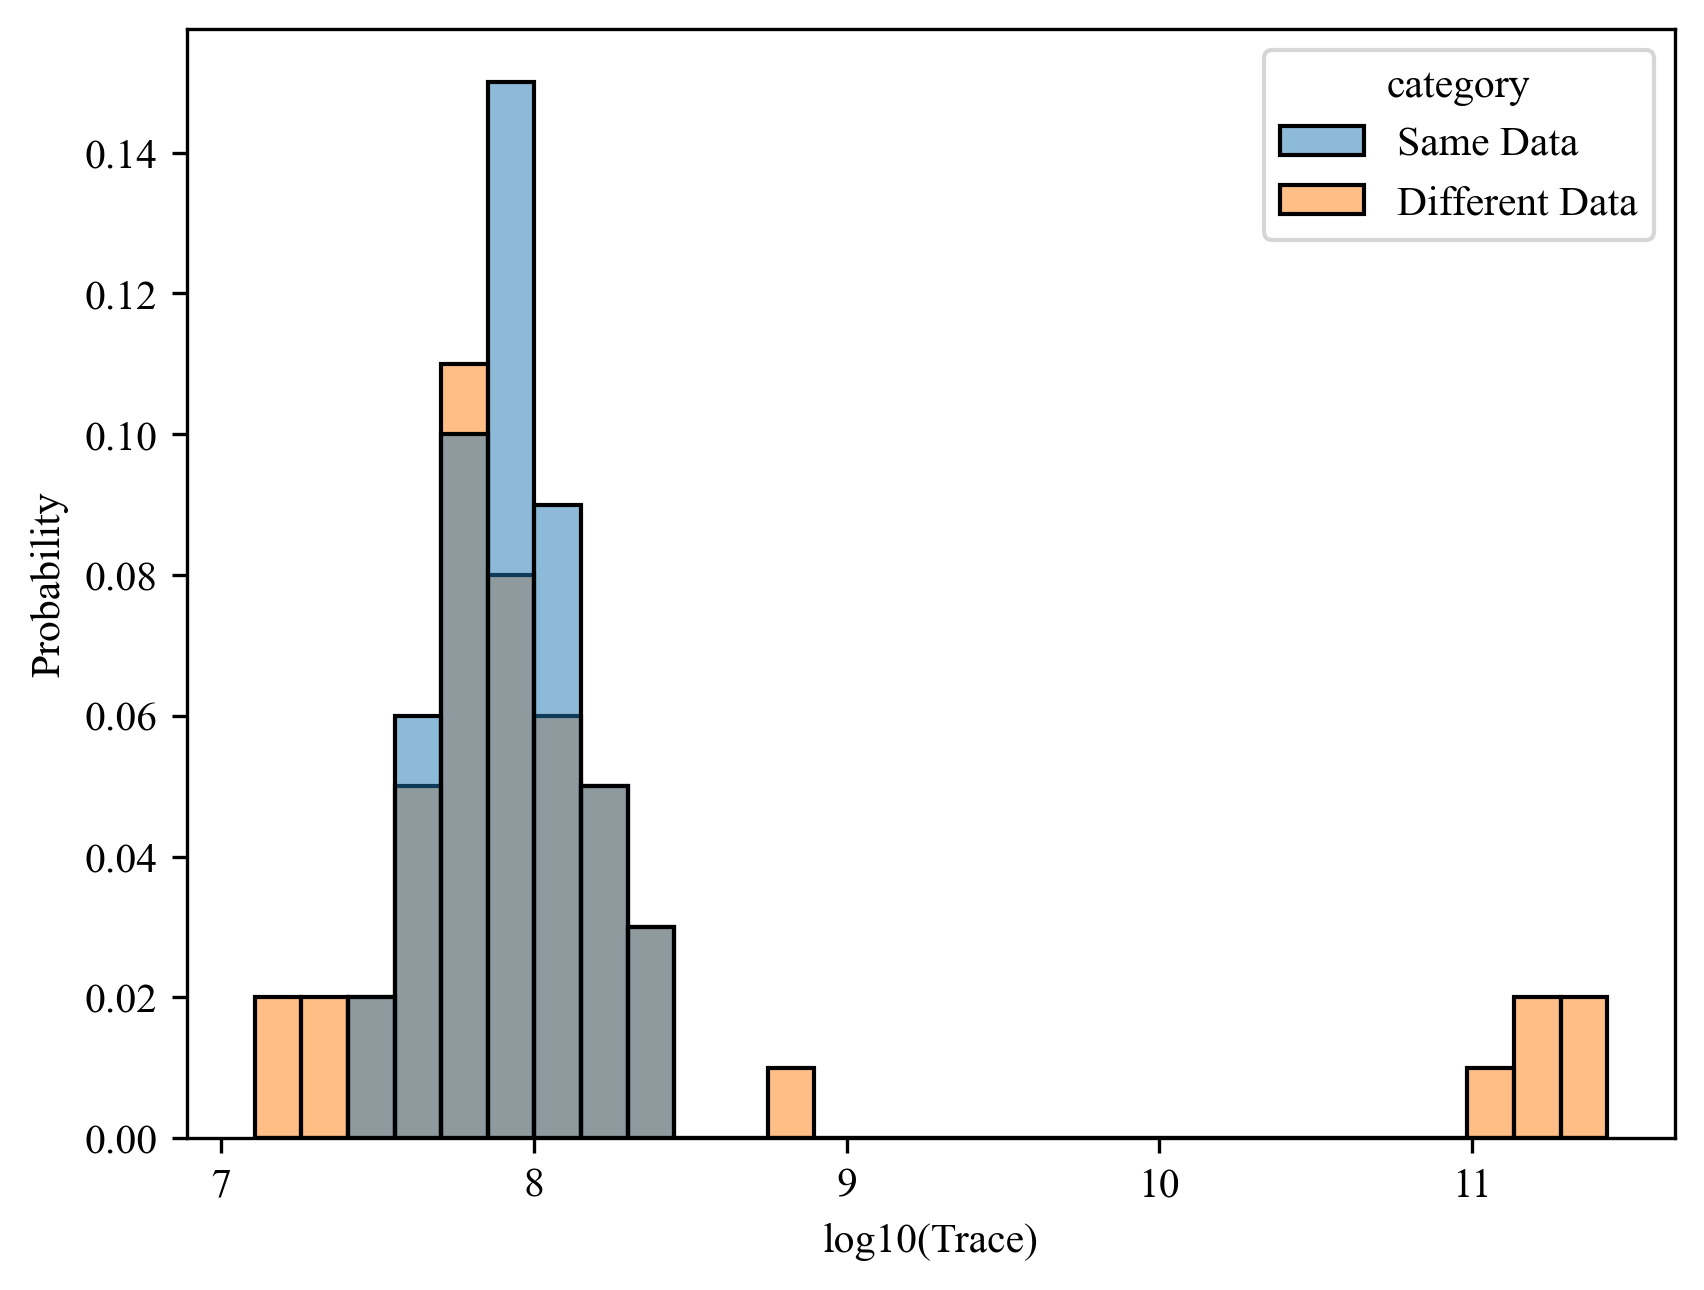

In [64]:
values = np.concatenate([traces_1, traces_diff])
values = np.log10(values)
xlabel = 'log10(Trace)'
data = pd.DataFrame({
    xlabel: values,
    'category': ['Same Data']*len(traces_1) + ['Different Data']*len(traces_diff)
})

sns.histplot(data=data, x=xlabel, hue='category', stat='probability') #, kde=True)

<AxesSubplot: xlabel='log(Trace)', ylabel='Probability'>

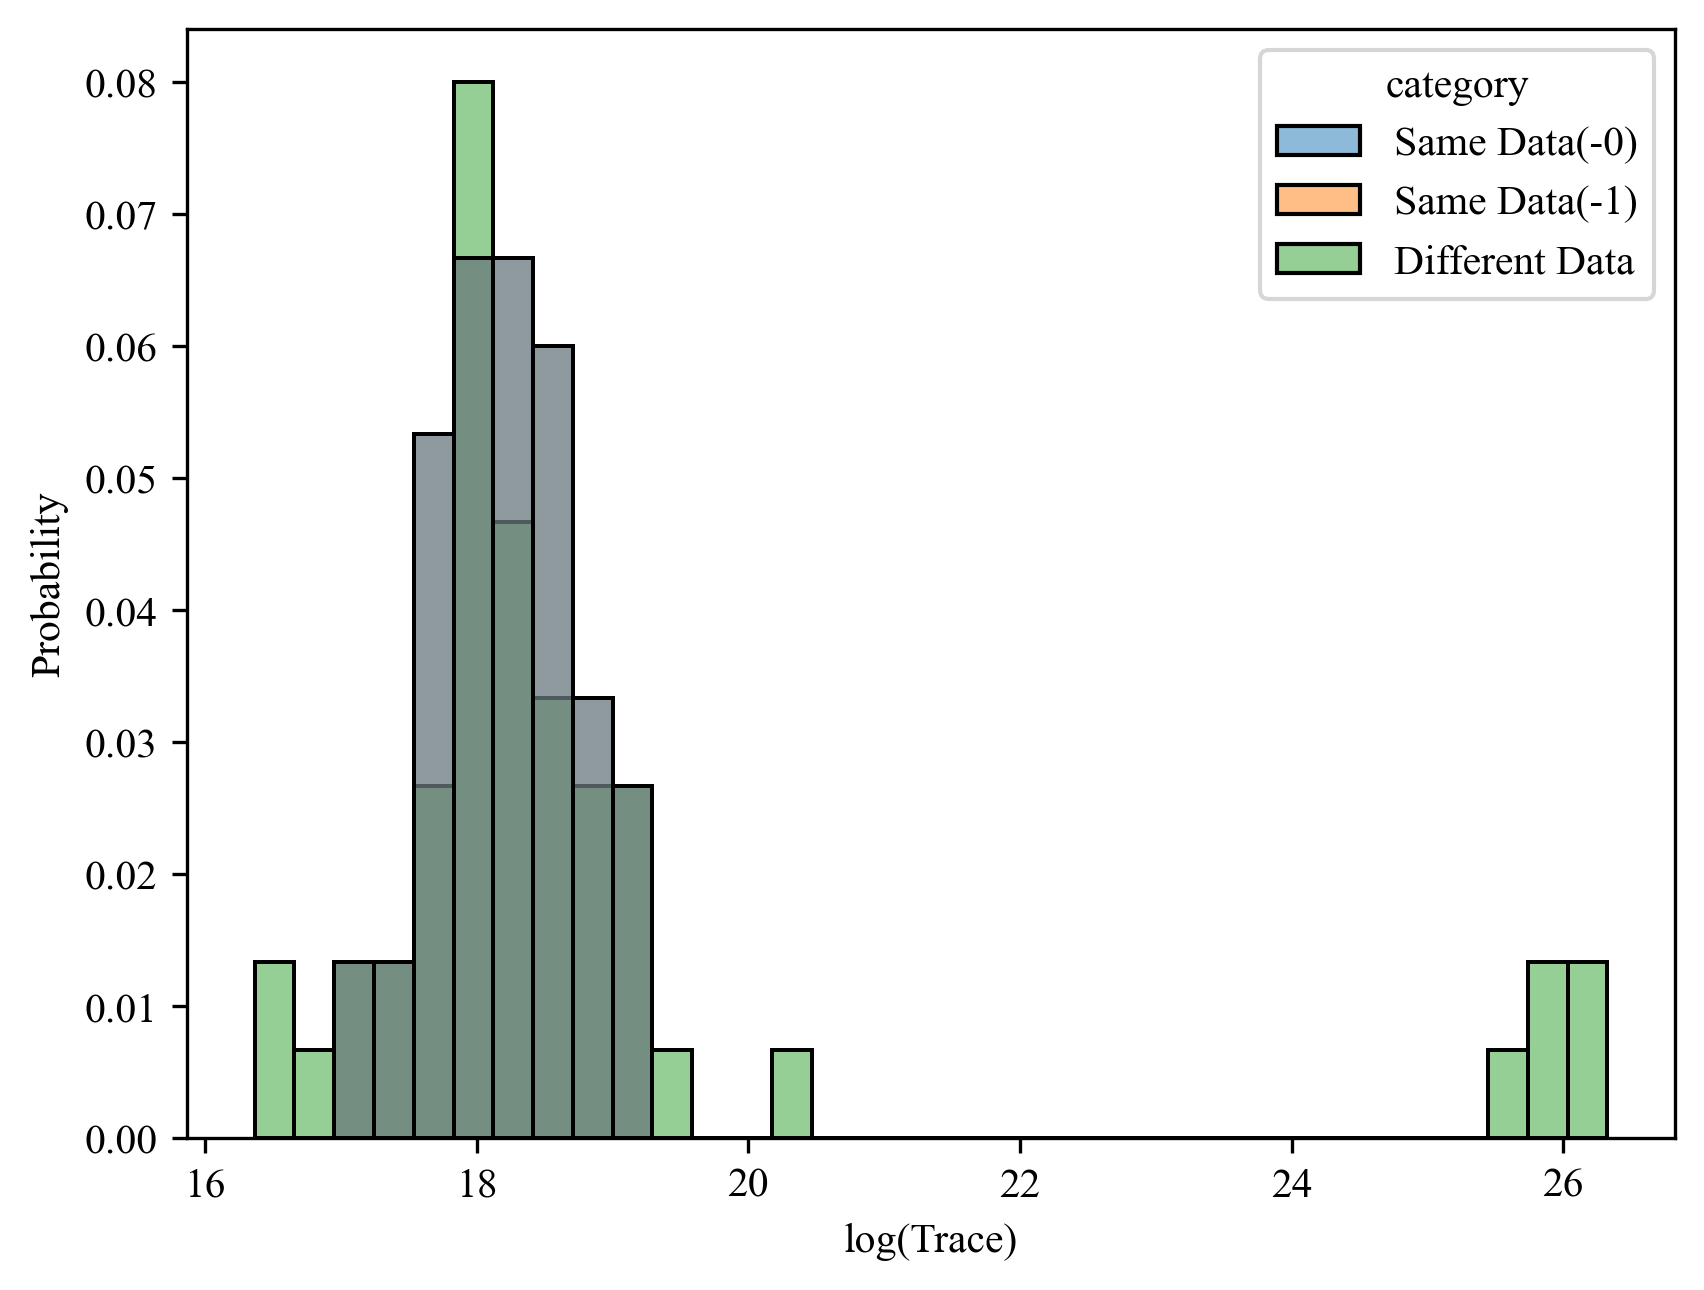

In [58]:
values = np.concatenate([traces, traces_1, traces_diff])
values = np.log(values)
xlabel = 'log(Trace)'
data = pd.DataFrame({
    xlabel: values,
    'category': ['Same Data(-0)']*len(traces_1) + ['Same Data(-1)']*len(traces_1) + ['Different Data']*len(traces_diff)
})

sns.histplot(data=data, x=xlabel, hue='category', stat='probability') #, kde=True)

In [59]:
traces

array([7.68444640e+07, 1.00856968e+08, 9.08976320e+07, 5.82457560e+07,
       9.23246320e+07, 4.53013000e+07, 3.02894260e+07, 9.69333360e+07,
       5.65086560e+07, 5.46762240e+07, 2.61392960e+07, 1.17542536e+08,
       5.43025440e+07, 7.18593040e+07, 5.30192640e+07, 7.72063440e+07,
       4.34539800e+07, 4.60663040e+07, 6.43212960e+07, 4.01942240e+07,
       5.16162000e+07, 1.35865792e+08, 5.62556600e+07, 9.37495200e+07,
       1.23604936e+08, 2.34733856e+08, 1.12842912e+08, 6.67574040e+07,
       7.69465360e+07, 1.30949528e+08, 9.37158000e+07, 1.41718976e+08,
       2.19379008e+08, 3.63047640e+07, 1.00627104e+08, 1.17875160e+08,
       1.43529200e+08, 7.36092960e+07, 5.00049360e+07, 1.21544248e+08,
       9.65082320e+07, 9.99384560e+07, 1.58368288e+08, 1.81920160e+08,
       8.91393840e+07, 7.16704640e+07, 7.00107200e+07, 7.35531520e+07,
       2.16101520e+08, 1.66974832e+08], dtype=float32)

In [62]:
traces_1

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])